<a href="https://colab.research.google.com/github/brunotagoncalves/MeLi_2021_demand_prediction/blob/main/meli_EDA_6th_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Data 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install catboost

     |████████████████████████████████| 69.2 MB 4.6 kB/s 


In [ ]:
!wget https://meli-data-challenge.s3.amazonaws.com/2021/test_data.csv -P drive/MyDrive/MeLi-2021/row/
!wget https://meli-data-challenge.s3.amazonaws.com/2021/train_data.parquet -P drive/MyDrive/MeLi-2021/row/
!wget https://meli-data-challenge.s3.amazonaws.com/2021/items_static_metadata_full.jl -P drive/MyDrive/MeLi-2021/row/
!wget https://meli-data-challenge.s3.amazonaws.com/2021/sample_submission.csv.gz -P drive/MyDrive/MeLi-2021/row/

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz 
!wget -P spark_tgz/ http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz

--2021-07-27 19:26:37--  http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving www-eu.apache.org (www-eu.apache.org)... 95.216.26.30, 2a01:4f9:2a:1a61::2
Connecting to www-eu.apache.org (www-eu.apache.org)|95.216.26.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz [following]
--2021-07-27 19:26:37--  https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 135.181.209.10, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235899716 (225M) [application/x-gzip]
Saving to: ‘spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz’

spark-2.4.8-bin-had 100%[===================>] 224.97M  18.3MB/s    in 14s     

2021-07-27 19:26:52 (16.5 MB/s) - ‘spark_tgz/spark-2

In [4]:
!tar -xf spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz -C spark_tgz/
!pip install -q findspark
!pip install -q pyspark

     |████████████████████████████████| 212.4 MB 67 kB/s 
     |████████████████████████████████| 198 kB 62.5 MB/s 


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark_tgz/spark-2.4.8-bin-hadoop2.7"

In [6]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()


In [7]:
import pyspark.sql.functions  as F

In [8]:
import pandas as pd 
import numpy as np


In [18]:
df_spark = spark.read.format('parquet').load("drive/MyDrive/MeLi-2021/row/train_data.parquet")

In [19]:
df_spark.count()

37660279

In [20]:
df_spark.createOrReplaceTempView('df')

In [21]:
spark.sql("""
SELECT df.*
  ,minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) diff_minutes_active
  ,(CASE WHEN minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) < 0 THEN 'Ruptura'END) Ruptura
  ,(CASE WHEN minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) > 0 THEN 'Estoque'END) Estoque
  
FROM df
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')

In [22]:
spark.sql("""
SELECT df_re.*
  ,CASE WHEN Ruptura is null and Estoque is null and minutes_active>0 and diff_minutes_active is null then 'Estoque'
        --WHEN Estoque is not null then 'Estoque'
        WHEN minutes_active = diff_minutes_active	and Estoque is not null then 'Estoque'
        --WHEN Ruptura is not null and Estoque is null then 'Ruptura'
        WHEN Ruptura is not null and Estoque is null and minutes_active=0  then 'Ruptura'
        END STATUS_RUPTURA
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [23]:
spark.sql("""
SELECT df_re.*
  ,COUNT(CASE WHEN STATUS_RUPTURA IS NOT NULL THEN 1 END) over (partition by sku order by date ) ciclo_ruptura
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [24]:
spark.sql("""
SELECT df_re.*
  ,SUM(sold_quantity) over (partition by sku,ciclo_ruptura order by date desc) sum_sold_quantity 
  ,sum(case when sold_quantity >0 then current_price*sold_quantity end) over (partition by sku,ciclo_ruptura order by date desc)/SUM(sold_quantity) over (partition by sku,ciclo_ruptura order by date desc) avg_current_price 
  ,SUM(minutes_active) over (partition by sku,ciclo_ruptura order by date desc)/60/24 days_active_nround
  ,round(SUM(minutes_active) over (partition by sku,ciclo_ruptura order by date desc) /60/24 + 0.5,0) days_active 
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [25]:
spark.sql("""
SELECT df_re.*  
  ,min(days_active_nround) over (partition by sku,ciclo_ruptura order by date desc)>0 FLG_ruptura 
FROM df_re
--where sku = 0
--order by sku, date
""").filter('FLG_ruptura=True').drop(*['sold_quantity','minutes_active','diff_minutes_active',	'Ruptura',	'Estoque',	'STATUS_RUPTURA',	'ciclo_ruptura']).createOrReplaceTempView('df_final')#.toPandas()

In [26]:
%%time
spark.sql("""
SELECT *
FROM df_final
""").repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/refine/df_final/')

CPU times: user 886 ms, sys: 99.2 ms, total: 986 ms
Wall time: 3min 20s


In [5]:
df = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/refine/df_final/')

In [6]:
df.count()

28096162

In [ ]:
spark.sql("""
SELECT sku
  , sum(sold_quantity) total_sold_quantity 
  , max(sold_quantity) max_sold_quantity 
  , min(case when sold_quantity>0 then sold_quantity end) min_sold_quantity 
  , avg(case when sold_quantity>0 then sold_quantity end) avg_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.5) median_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.25) qt1_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.75) qt3_sold_quantity 

  , sum(current_price*sold_quantity) total_fat 
  , max(current_price*sold_quantity) max_fat  
  , min(case when sold_quantity>0 then current_price*sold_quantity end) min_fat 
  , avg(case when sold_quantity>0 then current_price*sold_quantity end) avg_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.5) median_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.25) qt1_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.75) qt3_fat

  , sum(case when sold_quantity>0 then current_price*sold_quantity end)/sum(sold_quantity) avg_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.5)/sum(sold_quantity) median_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.25)/sum(sold_quantity) qt1_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.75)/sum(sold_quantity) qt3_price
FROM df
GROUP BY sku
""").repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/refine/agreg/')

In [30]:
g_df = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/refine/agreg/')
g_df.createOrReplaceTempView('g_df')

In [31]:
spark.read.format('json').load('drive/MyDrive/MeLi-2021/row/items_static_metadata_full.jl').createOrReplaceTempView('items')

In [32]:
spark.sql("""
SELECT df_final.sku ,
  date ,
  current_price ,
  currency ,
  listing_type ,
  shipping_logistic_type ,
  shipping_payment ,
  sum_sold_quantity ,
  avg_current_price ,
  days_active_nround ,
  days_active ,
  FLG_ruptura ,

  total_sold_quantity ,
  max_sold_quantity ,
  min_sold_quantity ,
  avg_sold_quantity ,
  median_sold_quantity ,
  qt1_sold_quantity ,
  qt3_sold_quantity ,
  total_fat ,
  max_fat ,
  min_fat ,
  avg_fat ,
  median_fat ,
  qt1_fat ,
  qt3_fat ,
  avg_price ,
  median_price ,
  qt1_price ,
  qt3_price ,
  item_domain_id ,
  item_id ,
  item_title ,
  product_family_id ,
  product_id ,
  site_id 

FROM df_final
LEFT JOIN g_df 
  ON g_df.sku = df_final.sku
LEFT JOIN items 
  ON items.sku = df_final.sku
""").createOrReplaceTempView('df_final_join')

In [33]:
spark.read.option("header",True).format('csv').load('drive/MyDrive/MeLi-2021/row/test_data.csv').createOrReplaceTempView('test_data')


In [34]:
spark.sql("""
SELECT test_data.sku ,
  target_stock ,
  total_sold_quantity ,
  max_sold_quantity ,
  min_sold_quantity ,
  avg_sold_quantity ,
  median_sold_quantity ,
  qt1_sold_quantity ,
  qt3_sold_quantity ,
  total_fat ,
  max_fat ,
  min_fat ,
  avg_fat ,
  median_fat ,
  qt1_fat ,
  qt3_fat ,
  avg_price ,
  median_price ,
  qt1_price ,
  qt3_price ,
  item_domain_id ,
  item_id ,
  item_title ,
  product_family_id ,
  product_id ,
  site_id 
FROM test_data
LEFT JOIN g_df 
  ON g_df.sku = test_data.sku
LEFT JOIN items 
  ON items.sku = test_data.sku
""").createOrReplaceTempView('test_data_join')

In [35]:
%%time
spark.sql("""
SELECT *
FROM df_final_join
""").repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/final/df_final_join/')

CPU times: user 1.56 s, sys: 196 ms, total: 1.75 s
Wall time: 5min 47s


In [36]:
%%time
spark.sql("""
SELECT *
FROM test_data_join
""").repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/final/test_data_join/')

CPU times: user 80.2 ms, sys: 7.08 ms, total: 87.3 ms
Wall time: 16.8 s


In [23]:
df_final = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/df_final_join/')
submit_data = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/test_data_join/')

In [24]:
submit_data = submit_data.withColumn('sum_sold_quantity',submit_data.target_stock)
#df_final = df_final.withColumn('target_stock',df_final.sum_sold_quantity)

In [25]:
df_final = df_final.filter("sum_sold_quantity>0") # estou na dúvida se deveriamos considerar como days como 30 nesse caso 
df_final = df_final.join(submit_data.select('sku','target_stock'),on='sku',how='left')

In [26]:
df_final = df_final.filter(F.expr("abs(sum_sold_quantity/target_stock-1)<0.3"))
#df_final = df_final.withColumn('target_stock',df_final.sum_sold_quantity)

In [27]:
df_final.count()

3748193

In [41]:
df_train, df_test = df_final.sample(fraction=150000/df_final.count(),seed=90).randomSplit([1.,1.],seed=123)

In [42]:
df_train.count(),df_test.count()

(75301, 75081)

In [43]:
from catboost import Pool, CatBoostClassifier

In [44]:
df_final.columns

['sku',
 'date',
 'current_price',
 'currency',
 'listing_type',
 'shipping_logistic_type',
 'shipping_payment',
 'sum_sold_quantity',
 'avg_current_price',
 'days_active_nround',
 'days_active',
 'FLG_ruptura',
 'total_sold_quantity',
 'max_sold_quantity',
 'min_sold_quantity',
 'avg_sold_quantity',
 'median_sold_quantity',
 'qt1_sold_quantity',
 'qt3_sold_quantity',
 'total_fat',
 'max_fat',
 'min_fat',
 'avg_fat',
 'median_fat',
 'qt1_fat',
 'qt3_fat',
 'avg_price',
 'median_price',
 'qt1_price',
 'qt3_price',
 'item_domain_id',
 'item_id',
 'item_title',
 'product_family_id',
 'product_id',
 'site_id',
 'target_stock']

In [53]:
vars = ['sku',
 'sum_sold_quantity','site_id','product_id','product_family_id','item_domain_id'
 ]
cat_vars =  ['sku',
             'site_id','product_id','product_family_id','item_domain_id'
 ]

In [54]:
df_train = df_train.fillna('sem_id', subset=cat_vars)
df_test = df_test.fillna('sem_id', subset=cat_vars) 
submit_data = submit_data.fillna('sem_id', subset=cat_vars) 

In [55]:
train_data = df_train.select(*vars+['days_active']).toPandas()
test_data = df_test.select(*vars+['days_active']).toPandas()
train_label = train_data.days_active
test_label = test_data.days_active

In [56]:
train_data.describe()

,sku,sum_sold_quantity,days_active
count,75301.000000,75301.000000,75301.000000
mean,329644.549621,21.327924,20.448122
std,190585.399917,129.936247,13.965048
min,37.000000,1.000000,1.000000
25%,165613.000000,4.000000,9.000000
50%,328637.000000,7.000000,17.000000
75%,494129.000000,15.000000,29.000000
max,660911.000000,18721.000000,60.000000


In [57]:
test_data.describe()

,sku,sum_sold_quantity,days_active
count,75081.000000,75081.000000,75081.000000
mean,330287.128887,21.403111,20.446132
std,190940.275526,124.864991,13.986001
min,27.000000,1.000000,1.000000
25%,164614.000000,4.000000,9.000000
50%,330769.000000,7.000000,17.000000
75%,495255.000000,15.000000,29.000000
max,660890.000000,18169.000000,60.000000


In [58]:
# initialize data
#train_data = g_df.loc[:,vars].sample(frac=.01,random_state=123)
#train_label = g_df.loc[:,'days_active'].apply(lambda x : x if x<30. else 30.).round().astype(int).sample(frac=.01,random_state=123)
#test_data = g_df.loc[~g_df.sku.isnull(),'current_price_count':'shipping_payment_shipping_payment']#.sample(frac=.1,random_state=1234)
# initialize Pool
train_pool = Pool(train_data.loc[:,vars], 
                  train_label, 
                  cat_features=cat_vars)
test_pool = Pool(test_data.loc[:,vars], 
                  test_label, 
                  cat_features=cat_vars)

# specify the training parameters 
model = CatBoostClassifier(task_type='GPU',metric_period=100,learning_rate=0.02)
#train the model
model.fit(train_pool,eval_set=test_pool)
# make the prediction using the resulting model

0:	learn: 4.0847760	test: 4.0865178	best: 4.0865178 (0)	total: 189ms	remaining: 3m 8s
100:	learn: 3.7537807	test: 3.7659940	best: 3.7659940 (100)	total: 13.6s	remaining: 2m 1s
200:	learn: 3.7160712	test: 3.7439203	best: 3.7439203 (200)	total: 27.6s	remaining: 1m 49s
300:	learn: 3.6999587	test: 3.7396782	best: 3.7396782 (300)	total: 40.6s	remaining: 1m 34s
400:	learn: 3.6870485	test: 3.7380192	best: 3.7380192 (400)	total: 53.4s	remaining: 1m 19s
500:	learn: 3.6763195	test: 3.7375780	best: 3.7375780 (500)	total: 1m 6s	remaining: 1m 5s
600:	learn: 3.6661424	test: 3.7378402	best: 3.7375780 (500)	total: 1m 19s	remaining: 52.6s
700:	learn: 3.6569302	test: 3.7382835	best: 3.7375780 (500)	total: 1m 32s	remaining: 39.3s
800:	learn: 3.6475935	test: 3.7388795	best: 3.7375780 (500)	total: 1m 45s	remaining: 26.1s
900:	learn: 3.6392686	test: 3.7396649	best: 3.7375780 (500)	total: 1m 57s	remaining: 12.9s
999:	learn: 3.6310063	test: 3.7405877	best: 3.7375780 (500)	total: 2m 10s	remaining: 0us
bestTest

In [59]:
pd.Series(model.feature_importances_,model.feature_names_).sort_values(ascending=False).cumsum()

sum_sold_quantity     31.847325
item_domain_id        55.512607
sku                   77.481034
site_id               87.385664
product_id            94.221808
product_family_id    100.000000
dtype: float64

In [60]:
model.score(test_pool),model.score(train_pool)

(0.04557744302819621, 0.06934834862750827)

In [191]:
model.score(test_pool),model.score(train_pool)

(0.043961530946746846, 0.051221083036248664)

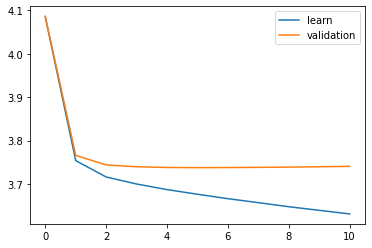

In [61]:
list_pd = [pd.DataFrame.from_dict(model.evals_result_[i]) for i in model.evals_result_]

list_pd = pd.concat(list_pd,axis=1)
list_pd.columns=[i for i in model.evals_result_]
list_pd.plot()


In [62]:
submit_pool = Pool(submit_data.select(*vars).toPandas(),
                 cat_features=cat_vars) 


In [63]:
preds= model.predict(submit_pool)
pd.DataFrame(preds).describe()#.hist()

,0
count,551472.000000
mean,9.209041
std,6.210950
min,1.000000
25%,4.000000
50%,9.000000
75%,12.000000
max,51.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d07074250>]],
      dtype=object)

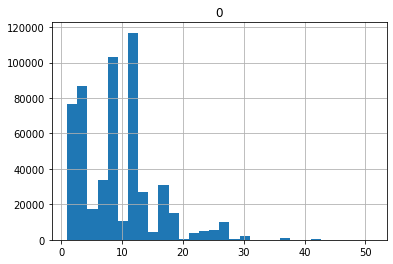

In [64]:
pd.DataFrame(preds).hist(bins=30)

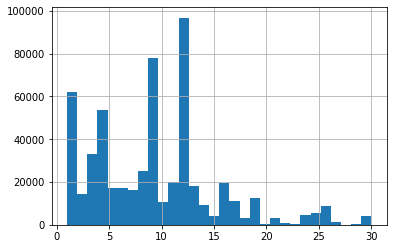

In [65]:
pd.DataFrame(preds).apply(lambda x : x[0] if x[0]<30 else 30,axis=1).hist(bins=30)

In [66]:
result = pd.DataFrame(model.predict_proba(submit_pool))#.round(4)#.to_csv("test_inner.csv.gz",compression='gzip',index=False,header=False)

In [67]:
result.loc[:,29] = result.loc[:,29:].sum(axis=1)#.apply(lambda x : x if x<1. else 1. )

In [68]:
(result.loc[:,:29].round(4)>1).any(axis=1).sum()

0

In [69]:
result.loc[:,:29].round(4).to_csv("drive/MyDrive/MeLi-2021/results/challenger.csv.gz",compression='gzip',index=False,header=False)

In [ ]:
result= pd.read_csv()
winner